<a href="https://colab.research.google.com/github/anujott-codes/Credit-Loan-Approval/blob/main/Loan_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from collections import Counter
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

##Loan Approval

###Import Dataset

In [2]:
#using loan approval dataset from kaggle
loan_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project/Credit Card and Loan Approval/loan_approval_dataset.csv')
loan_df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
loan_df = loan_df.drop(columns=['loan_id'])
loan_df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [4]:
loan_df = loan_df.rename(columns={
    ' income_annum':'annual_income',
    ' no_of_dependents':'no_of_dependents',
    ' education':'education',
    ' self_employed':'self_employed',
    ' loan_amount':'loan_amount',
    ' loan_term':'loan_term',
    ' cibil_score':'cibil_score',
    ' residential_assets_value':'residential_assets_value',
    ' commercial_assets_value':'commercial_assets_value',
    ' luxury_assets_value':'luxury_assets_value',
    ' bank_asset_value':'bank_asset_value',
    ' loan_status':'loan_status'
    })

##EDA

In [5]:
#Basic info about the dataset
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   annual_income             4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   luxury_assets_value       4269 non-null   int64 
 10  bank_asset_value          4269 non-null   int64 
 11  loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 400.3+ KB


In [6]:
#shape of the dataset
loan_df.shape

(4269, 12)

In [7]:
#checking for null values
loan_df.isna().sum()

,0
no_of_dependents,0
education,0
self_employed,0
annual_income,0
loan_amount,0
loan_term,0
cibil_score,0
residential_assets_value,0
commercial_assets_value,0
luxury_assets_value,0


In [8]:
#checking for duplicated values
loan_df.duplicated().sum()

np.int64(0)

In [9]:
#description about the data
loan_df.describe()

,no_of_dependents,annual_income,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


In [10]:
#extracting numerical features
numerical_features = loan_df.select_dtypes(exclude='O').columns.to_list()
print("----- Numerical Features -----")
print(numerical_features)
print(f"Total: {len(numerical_features)}")

print('\n')

#extracting categorical features
categorical_features = loan_df.select_dtypes(include='O').columns.to_list()
print("----- Categorical Features -----")
print(categorical_features)
print(f"Total: {len(categorical_features)}")

----- Numerical Features -----
['no_of_dependents', 'annual_income', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Total: 9


----- Categorical Features -----
['education', 'self_employed', 'loan_status']
Total: 3


In [11]:
#function to plot distributions
def plot(df, col ,num):
  plt.subplot(4,4,num)
  sns.histplot(data = df,x=col,kde=True, color='skyblue')
  plt.title(f"{col} Distribution")
  plt.xlabel(" ")

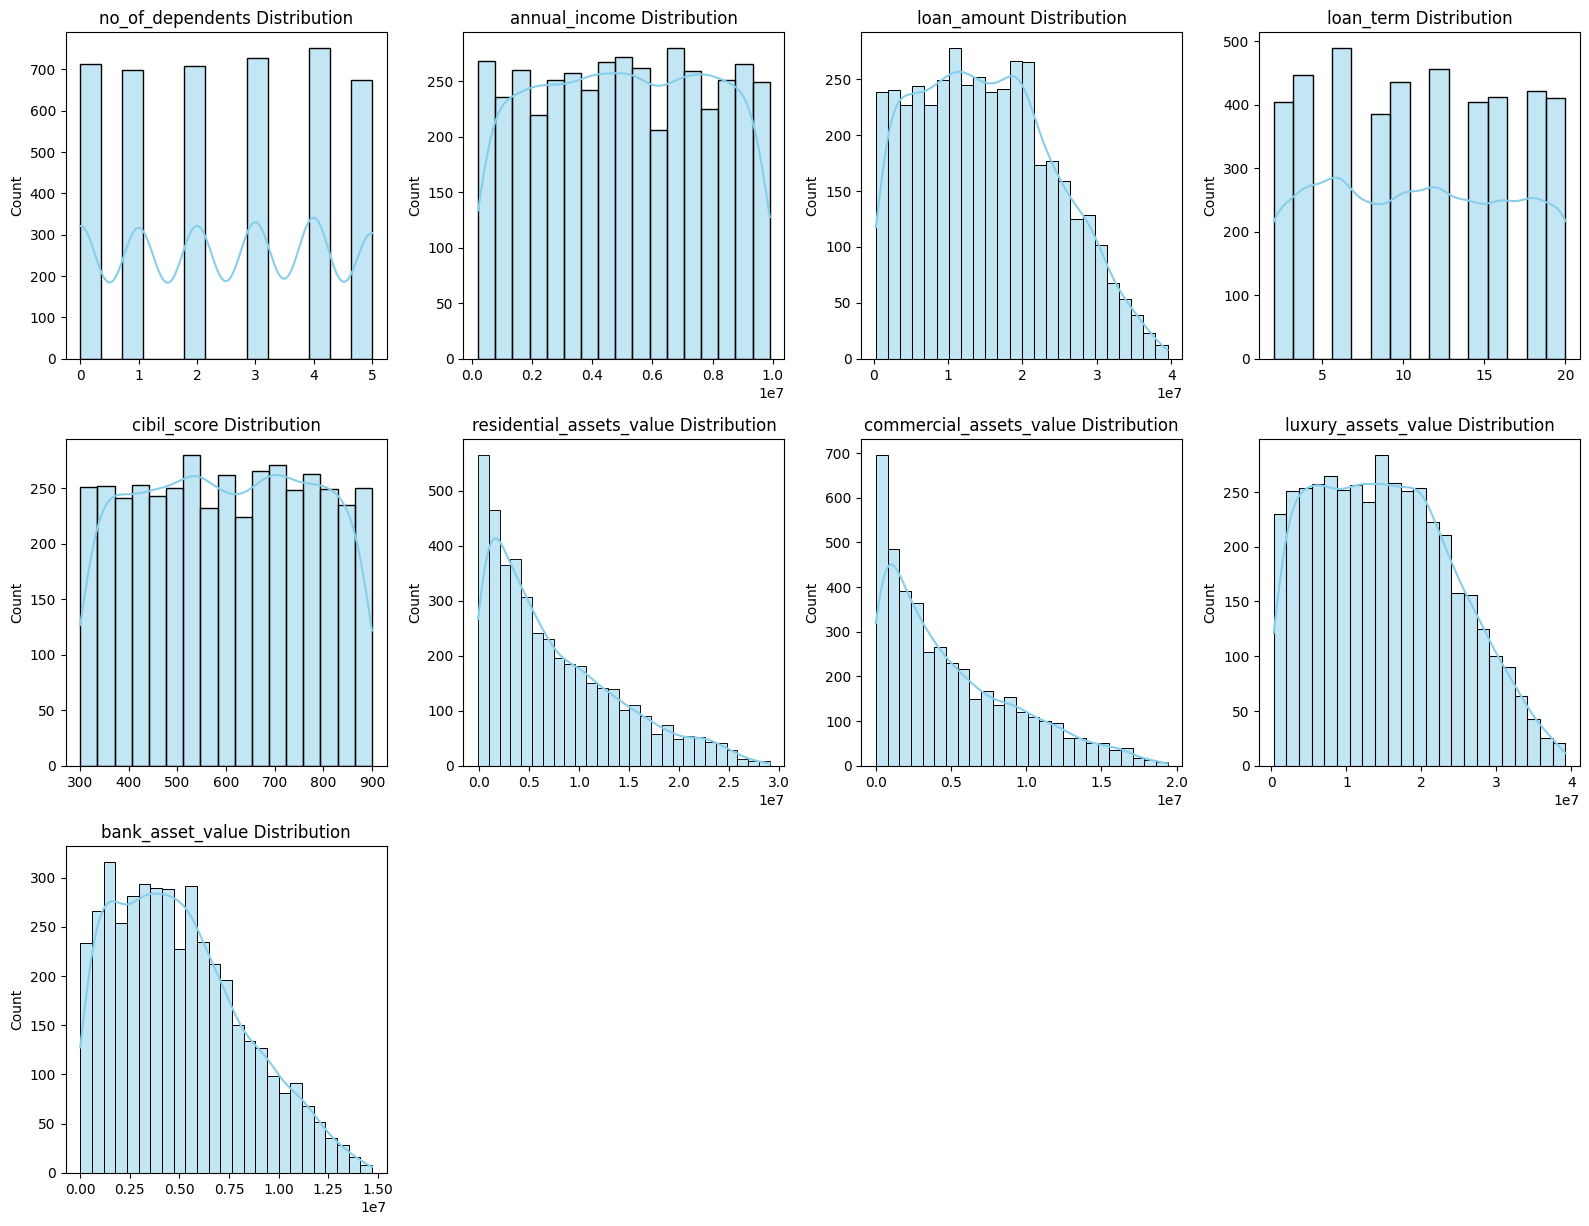

In [12]:
#plotting distributions
plt.figure(figsize=(16,16))
for i,col in enumerate(numerical_features):
  plot(loan_df,col,i+1)

plt.tight_layout()
plt.show()


In [13]:
#function for pie chart
def pie_plot(col, num, df=loan_df):
    plt.subplot(3,3,num)
    plt.pie(
        df[col].value_counts(),
        labels=df[col].value_counts().index,
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel')
    )
    plt.title(f"{col} Distribution")

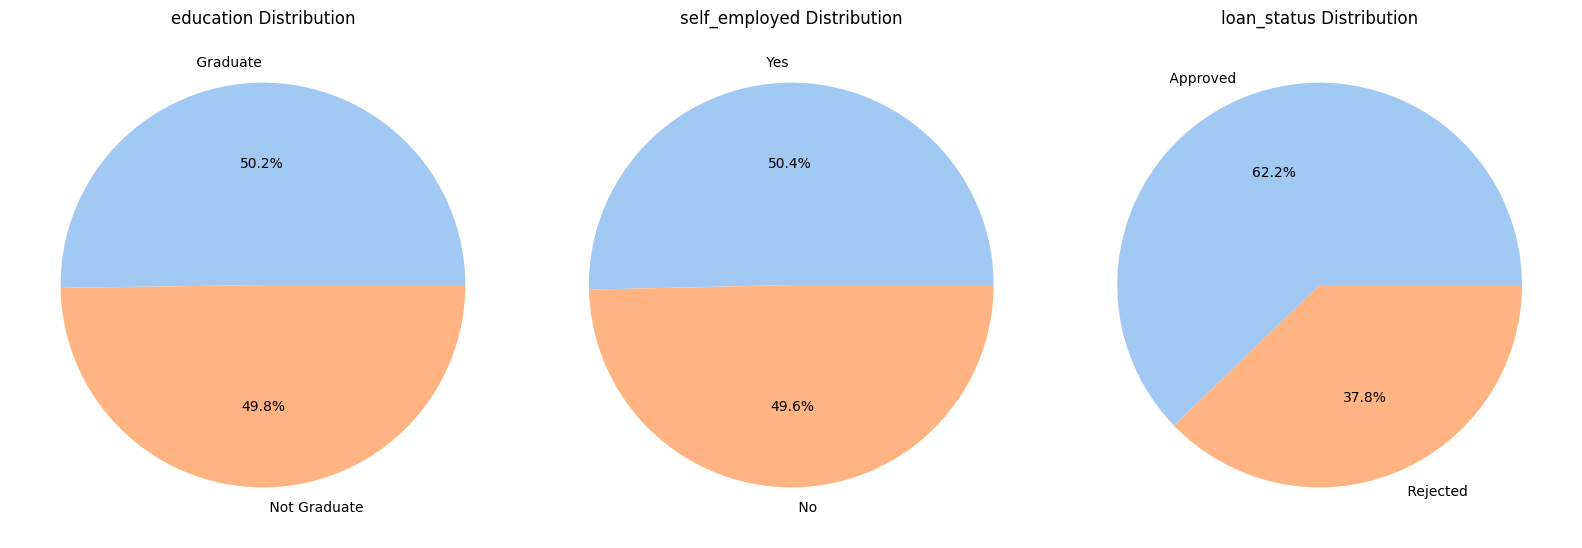

In [14]:
#pie chart for categorical features
plt.figure(figsize=(16,16))
for i,col in enumerate(categorical_features):
  pie_plot(col,i+1)

plt.tight_layout()
plt.show()

In [15]:
#converting target column into binary from categorical
loan_df['loan_status'].unique()
loan_df['loan_status'] = loan_df['loan_status'].map({' Approved':1,' Rejected':0})
loan_df['loan_status'] = loan_df['loan_status'].astype('int')
loan_df.head()

,no_of_dependents,education,self_employed,annual_income,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


In [16]:
#removing leading spaces for categorical columns
loan_df['education'] = loan_df['education'].apply(lambda x: x.lstrip())
loan_df['self_employed'] = loan_df['self_employed'].apply(lambda x: x.lstrip())

In [17]:
#rechecking transformations
print(loan_df['education'].unique())
print(loan_df['self_employed'].unique())

['Graduate' 'Not Graduate']
['No' 'Yes']


In [18]:
#encoding education and self_employed
loan_df['education'] = loan_df['education'].map({'Graduate':1,'Not Graduate':0})
loan_df['education'] = loan_df['education'].astype('int')

loan_df['self_employed'] = loan_df['self_employed'].map({'Yes':1,'No':0})
loan_df['self_employed'] = loan_df['self_employed'].astype('int')

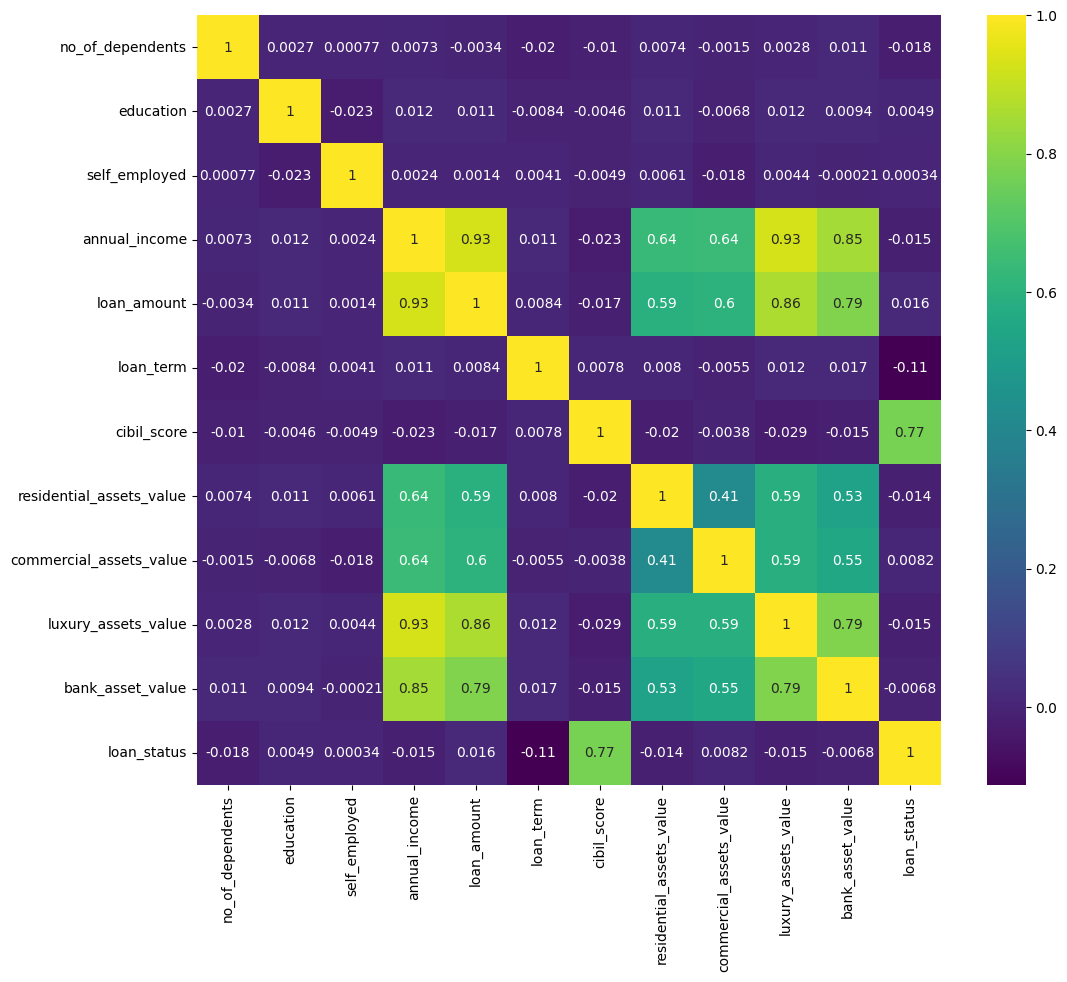

In [19]:
#check collinearity and feature correlation
plt.figure(figsize=(12,10))
numeric_df = loan_df.select_dtypes(exclude='O')
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, cmap='viridis',annot=True)
plt.show()

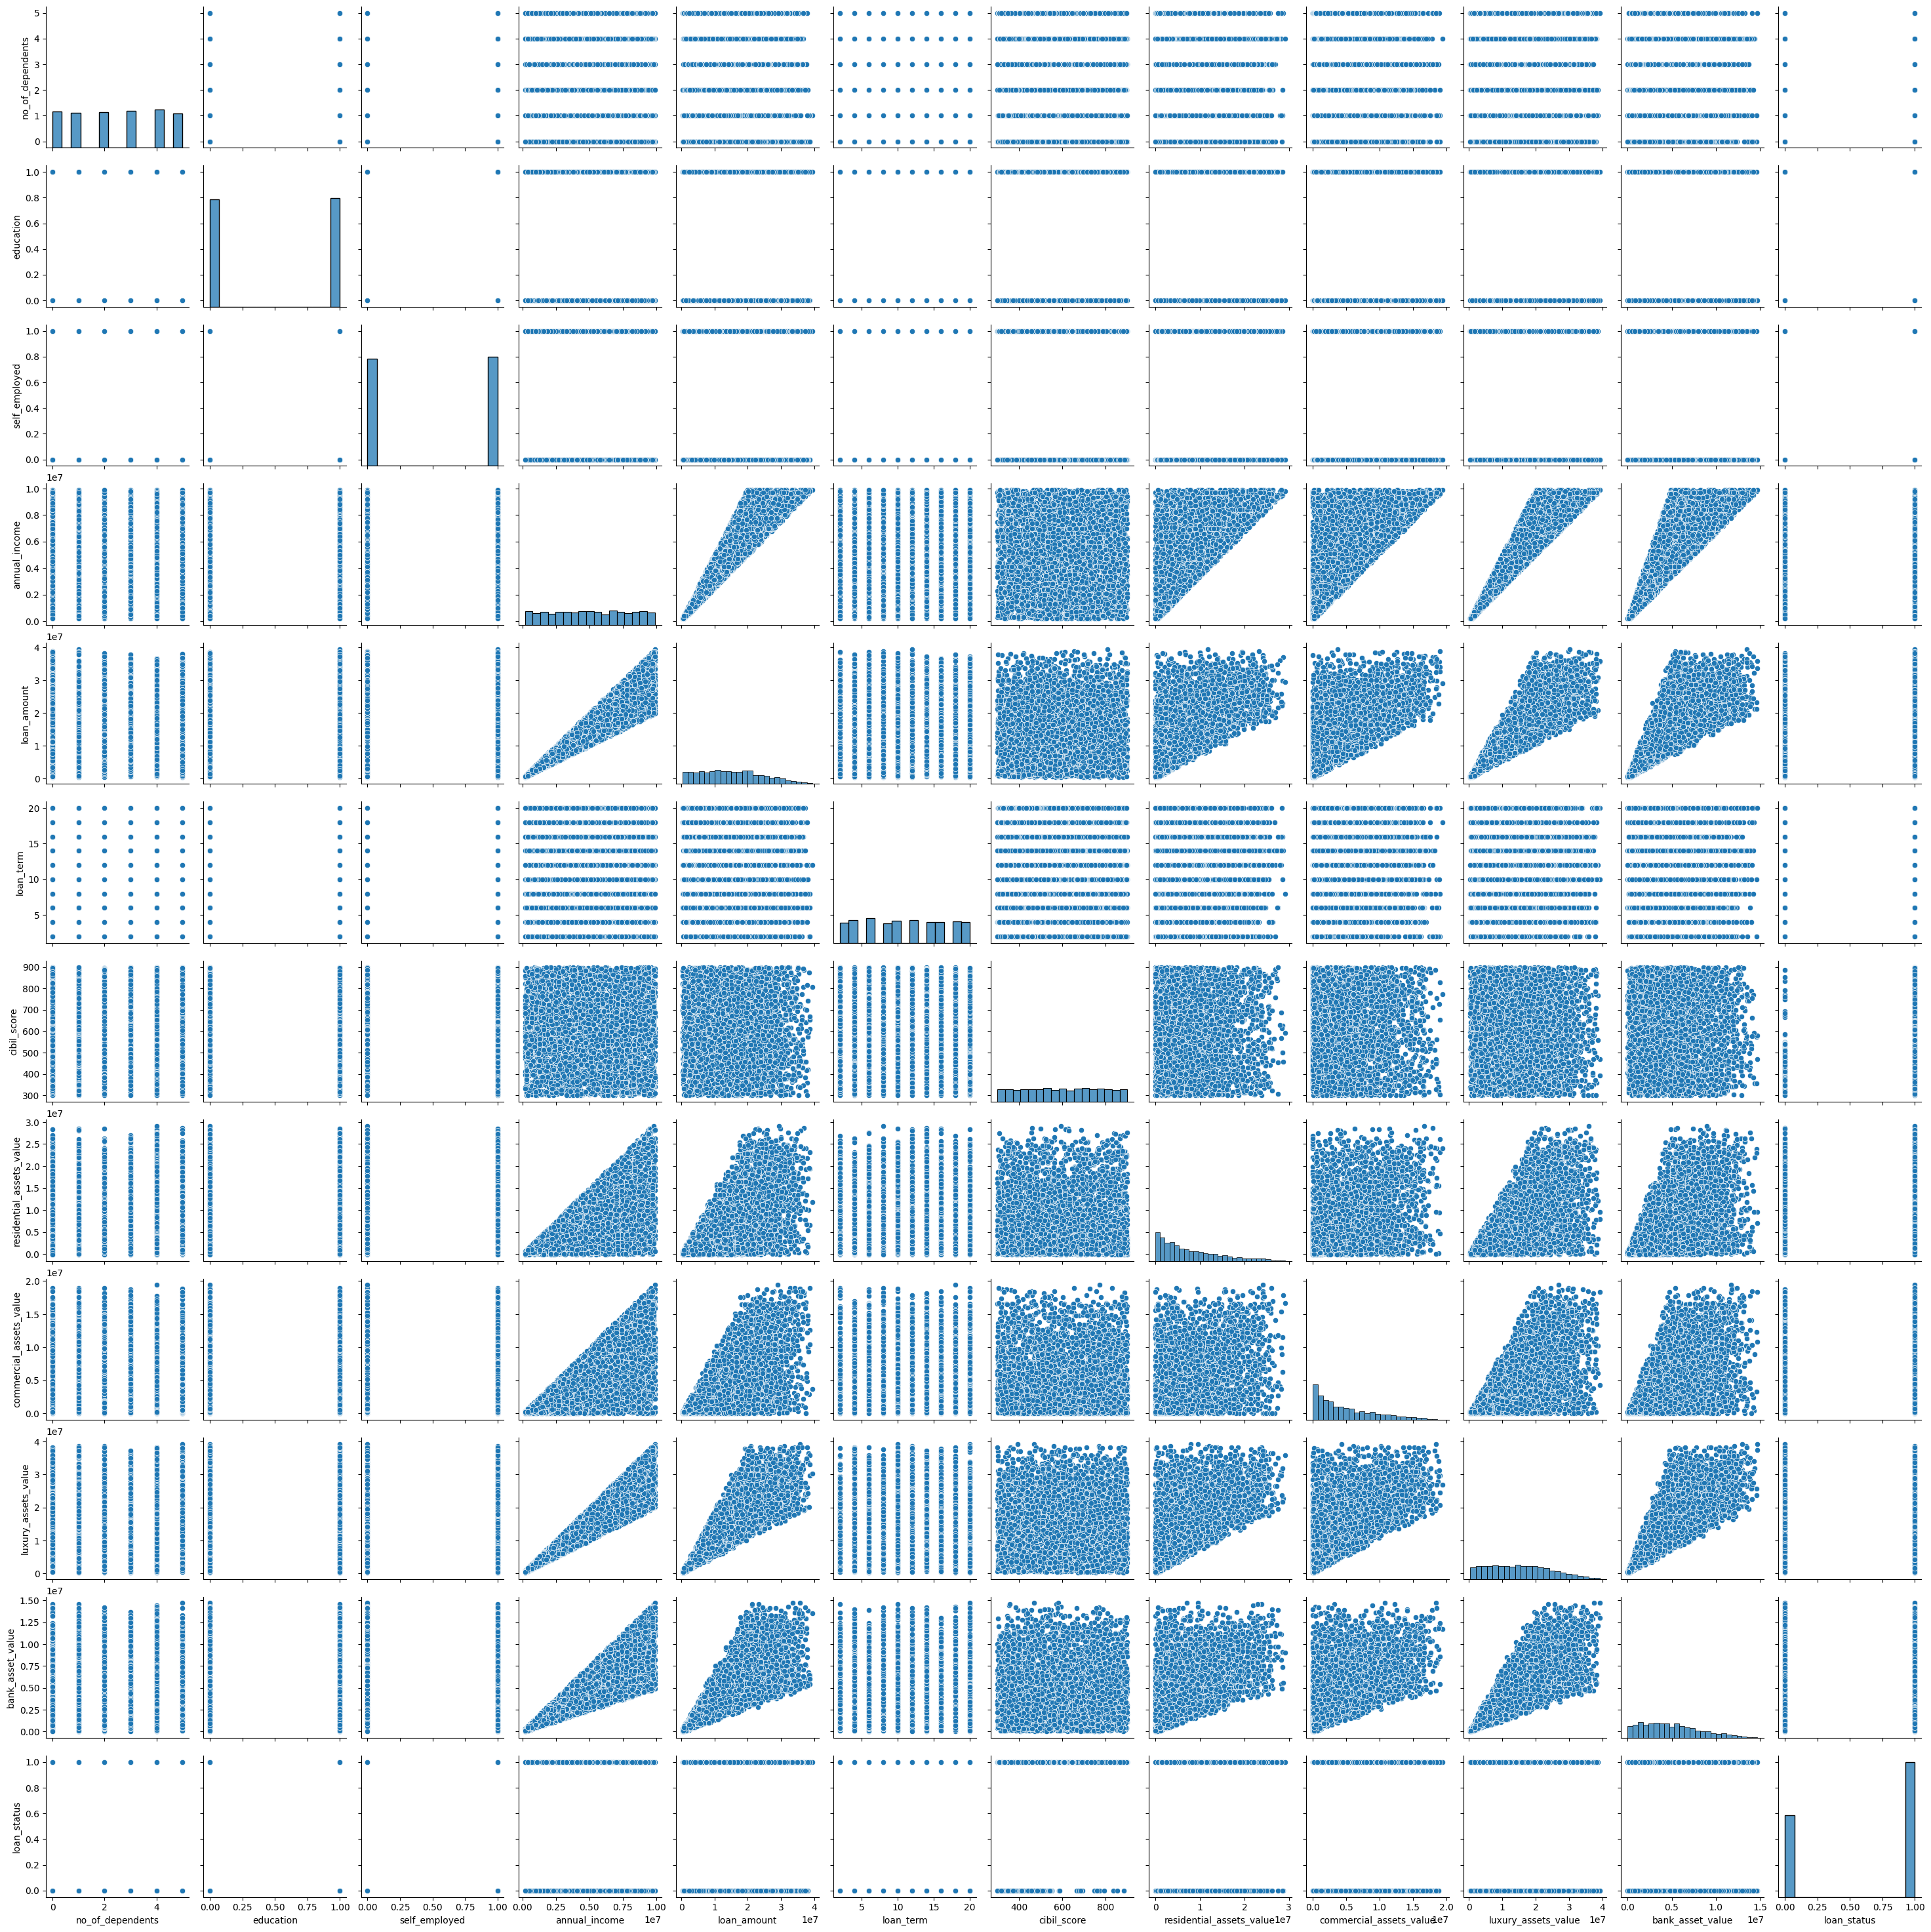

In [20]:
#pairplot
sns.pairplot(data=loan_df)
plt.show()

In [21]:
final_df = loan_df.copy()
final_df.shape

(4269, 12)

In [22]:
#extracting numerical features
numerical_features = final_df.select_dtypes(exclude='O').columns.to_list()
print("----- Numerical Features -----")
print(numerical_features)
print(f"Total: {len(numerical_features)}")

----- Numerical Features -----
['no_of_dependents', 'education', 'self_employed', 'annual_income', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']
Total: 12


In [23]:
#function for box plot to analyse outliers
def boxplot(col,num,df=final_df):
  plt.subplot(4,3,num)
  sns.set_style('dark')
  sns.boxplot(data = df,x = col, color='purple')
  plt.title(f'{col} Boxplot Distribution')

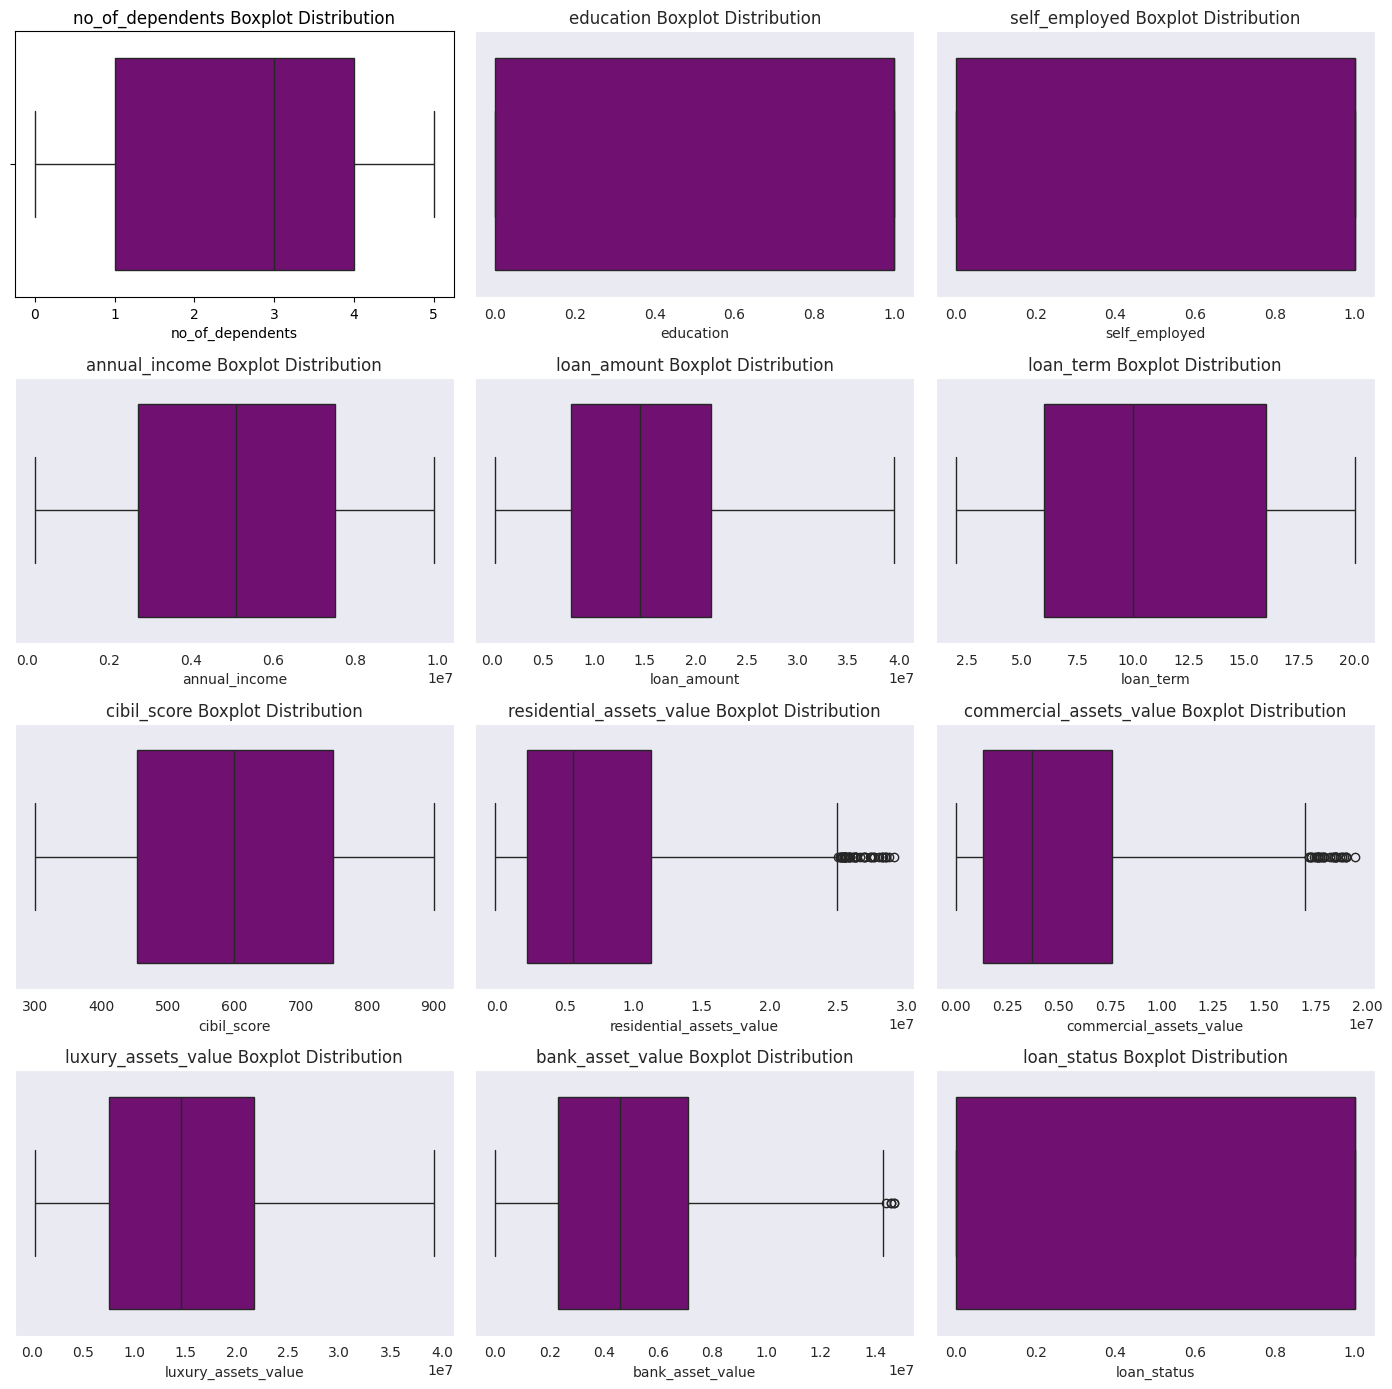

In [24]:
#plotting boxplot for continuous distributions
plt.figure(figsize=(14,14))
for i,col in enumerate(numerical_features):
  boxplot(col,i+1)

plt.tight_layout()
plt.show()

##Data Split

In [25]:
X = final_df.drop(columns=['loan_status'])
y = final_df['loan_status']

In [26]:
X.head()

,no_of_dependents,education,self_employed,annual_income,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000


In [27]:
X.shape

(4269, 11)

In [28]:
#data split for training set and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [29]:
X_train.head()

,no_of_dependents,education,self_employed,annual_income,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
1877,4,1,0,4800000,14300000,6,795,5900000,0,11100000,2600000
1729,3,1,1,5800000,16700000,18,633,8100000,8400000,14700000,3700000
164,2,1,1,8100000,22300000,18,737,22300000,12600000,27000000,7300000
2298,2,0,1,4400000,13900000,6,810,13200000,4200000,15000000,5200000
2461,5,1,0,6500000,24800000,8,779,7000000,9600000,15700000,8800000


In [30]:
X_test.head()

,no_of_dependents,education,self_employed,annual_income,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
2856,3,0,1,8300000,31400000,6,674,1000000,1600000,17200000,6100000
3176,4,0,1,3100000,8200000,18,408,2900000,3800000,10800000,3100000
477,1,1,0,8000000,31900000,12,504,23800000,1500000,22100000,6000000
4023,0,0,0,3800000,13300000,6,655,9600000,0,8600000,2600000
134,3,0,0,1500000,5500000,16,717,2100000,800000,4400000,1300000


In [31]:
numerical_features

['no_of_dependents',
 'education',
 'self_employed',
 'annual_income',
 'loan_amount',
 'loan_term',
 'cibil_score',
 'residential_assets_value',
 'commercial_assets_value',
 'luxury_assets_value',
 'bank_asset_value',
 'loan_status']

In [32]:
#setup preprocessor
features_to_pass = ['education','self_employed']
scaling_features = numerical_features
scaling_features.remove('education')
scaling_features.remove('self_employed')
scaling_features.remove('loan_status')


preprocessor = ColumnTransformer(
    transformers =[
        ('bin','passthrough',features_to_pass),
        ('num',StandardScaler(),scaling_features)
    ]
)

#preprocessing X_train and X_test
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [33]:
#saving preprocessor for deployment
joblib.dump(preprocessor,'loan_preprocessor.pkl')

['loan_preprocessor.pkl']

In [34]:
X_train_preprocessed

array([[ 1.        ,  0.        ,  0.89071783, ..., -1.13730558,
        -0.44443983, -0.73682658],
       [ 1.        ,  1.        ,  0.30110717, ...,  0.78599456,
        -0.04838711, -0.39679525],
       [ 1.        ,  1.        , -0.28850349, ...,  1.74764462,
         1.30479299,  0.71603457],
       ...,
       [ 1.        ,  1.        ,  0.30110717, ...,  0.32806595,
        -0.3894325 , -0.42770719],
       [ 1.        ,  0.        , -1.46772481, ..., -0.83965199,
        -0.6974735 ,  0.37600323],
       [ 1.        ,  0.        ,  0.30110717, ...,  1.47288746,
         1.43681056,  2.10707184]])

In [35]:
#checking class imbalance
print("Train:", Counter(y_train))
print("Test:", Counter(y_test))

Train: Counter({1: 2125, 0: 1290})
Test: Counter({1: 531, 0: 323})


##Model Selection

In [36]:
#Logistic Regression
lr = LogisticRegression(random_state = 42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold CV
lr_scores = cross_val_score(lr, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", lr_scores)
print("Mean accuracy:", lr_scores.mean())
print("Standard deviation:", lr_scores.std())

Accuracy scores for each fold: [0.9238653  0.93265007 0.89458272 0.92532943 0.89604685]
Mean accuracy: 0.9144948755490482
Standard deviation: 0.01594758278675269


In [37]:
#SVC
svc = SVC(random_state = 42,probability=True)

# Perform 5-fold CV
svc_scores = cross_val_score(svc, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", svc_scores)
print("Mean accuracy:", svc_scores.mean())
print("Standard deviation:", svc_scores.std())


Accuracy scores for each fold: [0.94729136 0.94289898 0.94875549 0.94729136 0.92240117]
Mean accuracy: 0.9417276720351392
Standard deviation: 0.009860883303357403


In [38]:
#KNN
knn = KNeighborsClassifier()

# Perform 5-fold CV
knn_scores = cross_val_score(knn, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", knn_scores)
print("Mean accuracy:", knn_scores.mean())
print("Standard deviation:", knn_scores.std())

Accuracy scores for each fold: [0.9136164  0.90922401 0.89311859 0.89311859 0.88872621]
Mean accuracy: 0.8995607613469986
Standard deviation: 0.009912919988176165


In [39]:
#Naive Bayes
nb = GaussianNB()

# Perform 5-fold CV
nb_scores = cross_val_score(nb, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", nb_scores)
print("Mean accuracy:", nb_scores.mean())
print("Standard deviation:", nb_scores.std())

Accuracy scores for each fold: [0.93997072 0.9341142  0.93557833 0.9238653  0.91068814]
Mean accuracy: 0.9288433382137627
Standard deviation: 0.010500978668838132


In [40]:
#RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold CV
rf_scores = cross_val_score(rf, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", rf_scores)
print("Mean accuracy:", rf_scores.mean())
print("Standard deviation:", rf_scores.std())

Accuracy scores for each fold: [0.98243045 0.97218155 0.98535871 0.98243045 0.9795022 ]
Mean accuracy: 0.9803806734992679
Standard deviation: 0.004498474815735642


In [41]:
#GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=22)

# Perform 5-fold CV
gb_scores = cross_val_score(gb, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", gb_scores)
print("Mean accuracy:", gb_scores.mean())
print("Standard deviation:", gb_scores.std())

Accuracy scores for each fold: [0.98243045 0.98096633 0.97510981 0.9795022  0.98682284]
Mean accuracy: 0.9809663250366032
Standard deviation: 0.003817980910806818


In [42]:
#XGBClassifier
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    objective='binary:logistic'
)

# Perform 5-fold CV
xgb_scores = cross_val_score(xgb, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", xgb_scores)
print("Mean accuracy:", xgb_scores.mean())
print("Standard deviation:", xgb_scores.std())

Accuracy scores for each fold: [0.98682284 0.98682284 0.98243045 0.98243045 0.98535871]
Mean accuracy: 0.9847730600292826
Standard deviation: 0.001986040990666249


RandomForest, GradientBoosting and XGBoost perform well

##Evaluation on Testing Set

In [43]:
#Random Forest
rf.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_rf = rf.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_rf = rf.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_rf = classification_report(y_train,ypred_train_rf)
print("----- Classification report for Training Set -----")
print(clf_report_train_rf)

#classification report for testing set
clf_report_test_rf = classification_report(y_test,ypred_test_rf)
print("----- Classification report for Testing Set -----")
print(clf_report_test_rf)

----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1290
           1       1.00      1.00      1.00      2125

    accuracy                           1.00      3415
   macro avg       1.00      1.00      1.00      3415
weighted avg       1.00      1.00      1.00      3415

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       323
           1       0.98      0.99      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [44]:
#Gradient Boosting
gb.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_gb = gb.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_gb = gb.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_gb = classification_report(y_train,ypred_train_gb)
print("----- Classification report for Training Set -----")
print(clf_report_train_gb)

#classification report for testing set
clf_report_test_gb = classification_report(y_test,ypred_test_gb)
print("----- Classification report for Testing Set -----")
print(clf_report_test_gb)

----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1290
           1       1.00      1.00      1.00      2125

    accuracy                           1.00      3415
   macro avg       1.00      1.00      1.00      3415
weighted avg       1.00      1.00      1.00      3415

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       323
           1       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [45]:
#XGBoost
xgb.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_xgb = xgb.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_xgb = xgb.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_xgb = classification_report(y_train,ypred_train_xgb)
print("----- Classification report for Training Set -----")
print(clf_report_train_xgb)

#classification report for testing set
clf_report_test_xgb = classification_report(y_test,ypred_test_xgb)
print("----- Classification report for Testing Set -----")
print(clf_report_test_xgb)

----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1290
           1       1.00      1.00      1.00      2125

    accuracy                           1.00      3415
   macro avg       1.00      1.00      1.00      3415
weighted avg       1.00      1.00      1.00      3415

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       323
           1       0.99      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



XGBoost performs best

##Hyper Parameter Tuning